In [1]:
#The following file paths are all absolute paths. You can replace them with relative paths at runtime, and the files are located in their respective folders.
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/train/")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                ]

In [3]:
def eval_err(suffix,env_name,method_index,layer_i):
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    net.cuda()
    net.double()
    Samples = 5000
    steps = 300
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/{}{}.npy".format(env_name,i)
            # if os.path.exists(test_data_path):
            #     test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/{}{}.npy".format(env_name,i))
            # else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/"+env_name+"_"+method+"layer{}.npy".format(layer_i),np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [4]:
suffix = "compareNN_A"
env_name = "DampingPendulum"
for i in range(5):
    #i = 2
    eval_err(suffix,env_name,method_index=5,layer_i=i+1)

KoopmanNonlinearA
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
KoopmanNonlinearA
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
KoopmanNonlinearA
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
KoopmanNonlinearA
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
KoopmanNonlinearA
torch.Size([301, 5000, 3])
torch.Size([5000, 22])
1
torch.Size([301, 5000, 3])

<>:16: DeprecationWarning: invalid escape sequence \P


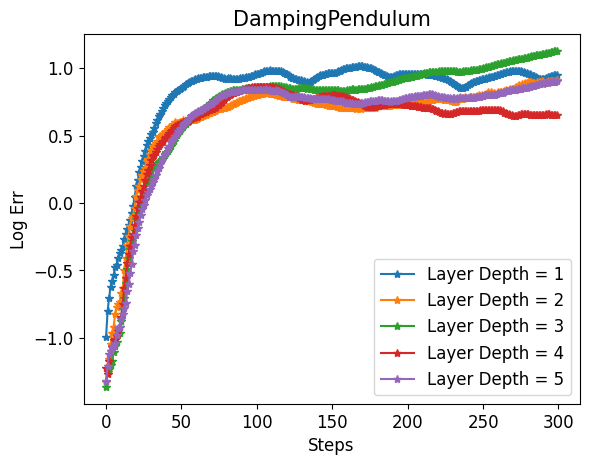

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}
method = Methods[5]
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
compare = "max"
#compare = "mean"
#i = 2
""" file_path = "D:\毕业设计\中期\Python\DeepKoopmanWithControl-main\Prediction_Results\SizeNN/"+"MountainCarContinuous-v0_KoopmanNonlinearAlayer{}.npy".format(i+1)
data = np.load(file_path) """
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(5):
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/"+env_name+"_"+method+"layer{}.npy".format(i+1)
    data = np.load(file_path)
    plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth = {}".format(i+1),linewidth=1.5)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
plt.savefig("D:/毕业设计/论文/pictures/sizeNN/"+env_name+"_TESTqaq_"+compare+"_new1.png",dpi=400)

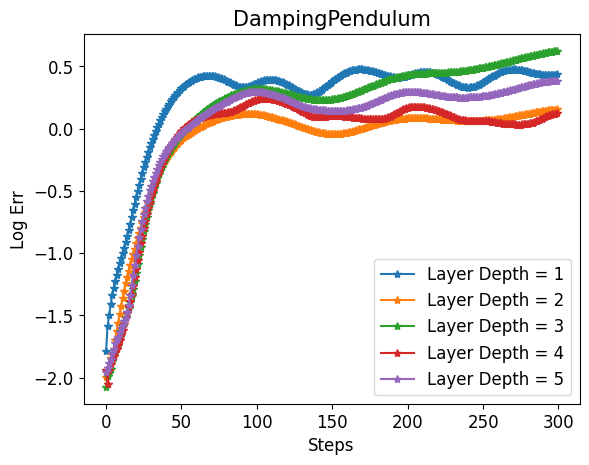

In [8]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
#compare = "max"
compare = "mean"
#i = 2
""" file_path = "D:\毕业设计\中期\Python\DeepKoopmanWithControl-main\Prediction_Results\SizeNN/"+"MountainCarContinuous-v0_KoopmanNonlinearAlayer{}.npy".format(i+1)
data = np.load(file_path) """
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(5):
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/sizeNN_data/compare_data/"+env_name+"_"+method+"layer{}.npy".format(i+1)
    data = np.load(file_path)
    plt.plot(np.log10(data[2]),'*-',color = colors[i],label="Layer Depth = {}".format(i+1),linewidth=1.5)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
plt.savefig("D:/毕业设计/论文/pictures/sizeNN/"+env_name+"_TESTqaq_"+compare+"_new1.png",dpi=400)